# Trip data duration regression

In [46]:
from pathlib import Path

PROJECT_DIR = Path().absolute().parent

## Download dataset

In [47]:
import os
import subprocess

DATA_DIR = PROJECT_DIR / "data"
S3_URL = "https://d37ci6vzurychx.cloudfront.net/trip-data/"
FILE_NAMES = ["green_tripdata_2021-01.parquet", "green_tripdata_2021-02.parquet"]


def download_data(file_name: str) -> None:
    file_path = DATA_DIR / file_name
    url = S3_URL + file_name

    if not os.path.isfile(file_path):
        print("File does not exist, downloading from S3 bucket.")
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))
        subprocess.run(['wget', "-O", file_path, url])
        print(f"File downloaded successfully and saved at {file_path}")
    else:
        print("File already exists.")

for file_name in FILE_NAMES:
    download_data(file_name)

File already exists.
File already exists.


## Train linear regression

In [31]:
import pickle

import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error


In [32]:
df = pd.read_parquet(DATA_DIR / "green_tripdata_2021-01.parquet")

df["duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
df["duration"] = df["duration"].apply(lambda td: td.total_seconds() / 60)

df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]

categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

df[categorical] = df[categorical].astype(str)

In [33]:
train_dicts = df[categorical + numerical].to_dict(orient="records")

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = "duration"
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.827368941909368

<Axes: ylabel='Count'>

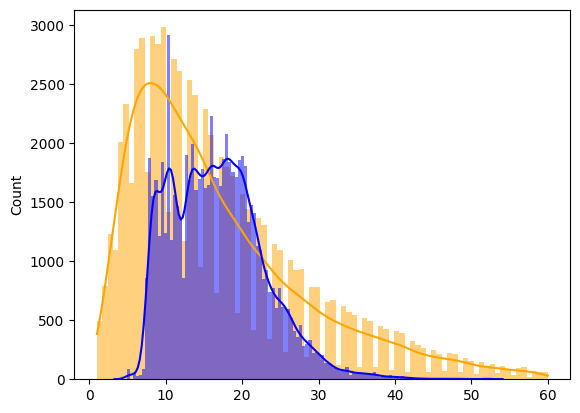

In [53]:
sns.histplot(y_train, color='orange', edgecolor=None, alpha=0.5, kde=True)
sns.histplot(y_pred, color='blue', edgecolor=None, alpha=0.5, kde=True)

In [58]:
def _read_csv_dataframe(filename: Path) -> pd.DataFrame:
    df = pd.read_csv(filename)
    for dt_col in ["lpep_dropoff_datetime", "lpep_pickup_datetime"]:
        df[dt_col] = pd.to_datetime(df[dt_col])
    return df


def _is_file_csv(filename: Path) -> bool:
    return filename.suffix == ".csv"


def _is_file_parquet(filename: Path) -> bool:
    return filename.suffix == ".parquet"


def read_dataframe(filename):
    if _is_file_csv(filename):
        df = _read_csv_dataframe(filename)
    elif _is_file_parquet(filename):
        df = pd.read_parquet(filename)

    df["duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
    df["duration"] = df["duration"].apply(lambda td: td.total_seconds() / 60)

    df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]

    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df

In [59]:
df_train = read_dataframe(DATA_DIR / "green_tripdata_2021-01.parquet")
df_val = read_dataframe(DATA_DIR / "green_tripdata_2021-02.parquet")

In [60]:
len(df_train), len(df_val)

(73908, 61921)

In [61]:
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]

In [62]:
categorical = ["PU_DO"]  #'PULocationID', 'DOLocationID']
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [63]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [64]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715208269472

### Save model

In [67]:
MODEL_DIR = PROJECT_DIR / "models"

os.makedirs(MODEL_DIR, exist_ok=True)

with open(MODEL_DIR / "lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

In [68]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728